# Model training

In [1]:
import os

SPRITE_DIRECTORY = 'sprites'
TRAIN_DATA_DIRECTORY = os.path.join(SPRITE_DIRECTORY, 'training')
TEST_DATA_DIRECTORY = os.path.join(SPRITE_DIRECTORY, 'test')

## Set up data flow

In [2]:
import tensorflow

IMAGE_SIZE = 128
BATCH_SIZE = 32

print(f'Flowing from {TRAIN_DATA_DIRECTORY}')
varying_image_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.05
)
train_image_generator = varying_image_generator.flow_from_directory(
    directory=TRAIN_DATA_DIRECTORY,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
    batch_size=BATCH_SIZE,
    color_mode='rgba',
    save_to_dir='/generated'
)
print(f'Flowing from {TEST_DATA_DIRECTORY}')
constant_image_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
test_image_generator = constant_image_generator.flow_from_directory(
    directory=TEST_DATA_DIRECTORY,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=False,
    color_mode='rgba',
    batch_size=BATCH_SIZE
)

Flowing from sprites\training
Found 205 images belonging to 2 classes.
Flowing from sprites\test
Found 23 images belonging to 2 classes.


## Count data

In [3]:
import os

def get_file_count_in_subdirectories_of(directory):
    subdirectories = os.listdir(directory)
    sum = 0
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(directory, subdirectory)
        files = os.listdir(subdirectory_path)
        file_count = len(files)
        sum = sum + file_count
    print(f'Found {sum} files in {directory}')
    return sum

TRAIN_DATA_COUNT = get_file_count_in_subdirectories_of(TRAIN_DATA_DIRECTORY)
TEST_DATA_COUNT = get_file_count_in_subdirectories_of(TEST_DATA_DIRECTORY)

Found 205 files in sprites\training
Found 23 files in sprites\test


## View data

In [4]:
import matplotlib.pyplot as plot
import numpy

sample_training_images, labels = next(test_image_generator)
class_label = {v:k for k,v in test_image_generator.class_indices.items()}
fig, axes = plot.subplots(4, 5, figsize=(10, 10))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[numpy.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plot.tight_layout()

## Build network

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 4)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='sigmoid')
])

The model now looks like this

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      592       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

## Train model

In [7]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

snapshot_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath="./.snapshots"
)

EPOCHS = 200
STEPS = TRAIN_DATA_COUNT / BATCH_SIZE
VALIDATION_STEPS = TEST_DATA_COUNT / BATCH_SIZE

history = model.fit_generator(
    steps_per_epoch=STEPS,
    epochs=EPOCHS,
    generator=train_image_generator,
    #callbacks=[snapshot_callback],
    validation_data=test_image_generator,
    validation_steps=VALIDATION_STEPS
)
print('Done training')

Epoch 1/200
7/6 [================================] - 4s 593ms/step - loss: 0.9151 - accuracy: 0.5268 - val_loss: 0.9359 - val_accuracy: 0.5652
Epoch 2/200
7/6 [================================] - 4s 610ms/step - loss: 0.6729 - accuracy: 0.5854 - val_loss: 0.9395 - val_accuracy: 0.5870
Epoch 3/200
7/6 [================================] - 4s 592ms/step - loss: 0.6762 - accuracy: 0.5756 - val_loss: 0.9224 - val_accuracy: 0.5652
Epoch 4/200
7/6 [================================] - 4s 571ms/step - loss: 0.6628 - accuracy: 0.5780 - val_loss: 0.8902 - val_accuracy: 0.5652
Epoch 5/200
7/6 [================================] - 4s 566ms/step - loss: 0.6358 - accuracy: 0.6000 - val_loss: 0.8097 - val_accuracy: 0.6957
Epoch 6/200
7/6 [================================] - 4s 610ms/step - loss: 0.6126 - accuracy: 0.6439 - val_loss: 0.7389 - val_accuracy: 0.7826
Epoch 7/200
7/6 [================================] - 4s 606ms/step - loss: 0.5675 - accuracy: 0.7146 - val_loss: 0.6301 - val_accuracy: 0.8478

Epoch 58/200
7/6 [================================] - 5s 660ms/step - loss: 0.0316 - accuracy: 0.9951 - val_loss: 0.7221 - val_accuracy: 0.8696
Epoch 59/200
7/6 [================================] - 4s 586ms/step - loss: 0.0558 - accuracy: 0.9854 - val_loss: 0.8749 - val_accuracy: 0.8261
Epoch 60/200
7/6 [================================] - 5s 644ms/step - loss: 0.0415 - accuracy: 0.9902 - val_loss: 0.7871 - val_accuracy: 0.8696
Epoch 61/200
7/6 [================================] - 5s 673ms/step - loss: 0.0965 - accuracy: 0.9951 - val_loss: 1.4265 - val_accuracy: 0.7826
Epoch 62/200
7/6 [================================] - 4s 537ms/step - loss: 0.0544 - accuracy: 0.9902 - val_loss: 0.5644 - val_accuracy: 0.9565
Epoch 63/200
7/6 [================================] - 5s 702ms/step - loss: 0.0766 - accuracy: 0.9707 - val_loss: 1.0398 - val_accuracy: 0.8261
Epoch 64/200
7/6 [================================] - 4s 597ms/step - loss: 0.0889 - accuracy: 0.9634 - val_loss: 0.6894 - val_accuracy:

Epoch 115/200
7/6 [================================] - 5s 698ms/step - loss: 0.0231 - accuracy: 0.9854 - val_loss: 0.7931 - val_accuracy: 0.8696
Epoch 116/200
7/6 [================================] - 6s 786ms/step - loss: 0.0191 - accuracy: 0.9902 - val_loss: 0.7515 - val_accuracy: 0.8696
Epoch 117/200
7/6 [================================] - 5s 672ms/step - loss: 0.0217 - accuracy: 0.9854 - val_loss: 0.7561 - val_accuracy: 0.8696
Epoch 118/200
7/6 [================================] - 6s 899ms/step - loss: 0.0147 - accuracy: 0.9951 - val_loss: 0.8314 - val_accuracy: 0.8696
Epoch 119/200
7/6 [================================] - 4s 632ms/step - loss: 0.0183 - accuracy: 0.9878 - val_loss: 0.8718 - val_accuracy: 0.8696
Epoch 120/200
7/6 [================================] - 5s 701ms/step - loss: 0.0125 - accuracy: 0.9951 - val_loss: 0.8179 - val_accuracy: 0.8696
Epoch 121/200
7/6 [================================] - 6s 824ms/step - loss: 0.0242 - accuracy: 0.9878 - val_loss: 0.8204 - val_ac

7/6 [================================] - 4s 593ms/step - loss: 0.0381 - accuracy: 0.9878 - val_loss: 1.0235 - val_accuracy: 0.9130
Epoch 172/200
7/6 [================================] - 4s 576ms/step - loss: 0.0532 - accuracy: 0.9854 - val_loss: 1.2248 - val_accuracy: 0.8043
Epoch 173/200
7/6 [================================] - 4s 581ms/step - loss: 0.0468 - accuracy: 0.9805 - val_loss: 0.7868 - val_accuracy: 0.8696
Epoch 174/200
7/6 [================================] - 4s 563ms/step - loss: 0.0503 - accuracy: 0.9756 - val_loss: 1.2413 - val_accuracy: 0.7826
Epoch 175/200
7/6 [================================] - 4s 550ms/step - loss: 0.0368 - accuracy: 0.9854 - val_loss: 0.9884 - val_accuracy: 0.8261
Epoch 176/200
7/6 [================================] - 4s 576ms/step - loss: 0.0177 - accuracy: 0.9902 - val_loss: 0.9187 - val_accuracy: 0.8913
Epoch 177/200
7/6 [================================] - 4s 592ms/step - loss: 0.0183 - accuracy: 0.9878 - val_loss: 0.9380 - val_accuracy: 0.9130

## Evaluate score

In [8]:
import numpy
from sklearn import metrics

prediction = model.predict(test_image_generator)
prediction = numpy.argmax(prediction, axis=1)
images, actual = next(test_image_generator)
actual = numpy.argmax(actual, axis=1)
print(actual)
score = metrics.accuracy_score(actual, prediction)
print(f'Final Score: {score}')

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
Final Score: 0.9130434782608695


## Monitor training

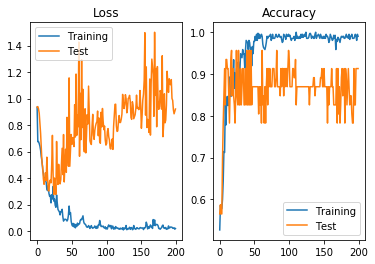

In [9]:
import matplotlib.pyplot as plot

LOSS = history.history['loss']
LOSS_VALIDATION = history.history['val_loss']

ACCURACY = history.history['accuracy']
ACCURACY_VALIDATION = history.history['val_accuracy']

EPOCHS_RANGE = range(EPOCHS)

plot.figure()
plot.subplot(1, 2, 1)
plot.plot(EPOCHS_RANGE, LOSS, label='Training')
plot.plot(EPOCHS_RANGE, LOSS_VALIDATION, label='Test')
plot.legend()
plot.title('Loss')

plot.subplot(1, 2, 2)
plot.plot(EPOCHS_RANGE, ACCURACY, label='Training')
plot.plot(EPOCHS_RANGE, ACCURACY_VALIDATION, label='Test')
plot.legend()
plot.title('Accuracy')

plot.show()

## Confusion matrix

Because the dataset is not balanced (i.e. there are more water than grass sprites), the values in the confusion matrix need to be normalized. Otherwise, the calculation will be biased towards the water sprites.

Text(0.5, 0, 'Predicted')

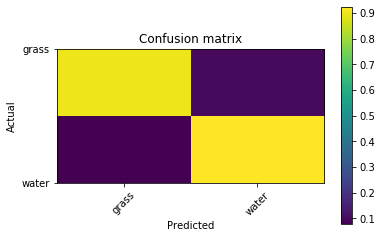

In [10]:
import matplotlib.pyplot as plot
from sklearn import metrics
import numpy

class_names = ['grass', 'water']
confusion_matrix = metrics.confusion_matrix(actual, prediction)
normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1)[:, numpy.newaxis]
plot.imshow(normalized_confusion_matrix)
plot.title('Confusion matrix')
plot.colorbar()
tick_marks = [0, 1]
plot.xticks(tick_marks, class_names, rotation=45)
plot.yticks(tick_marks, class_names)
plot.ylabel('Actual')
plot.xlabel('Predicted')

## Plot ROC

Text(0, 0.5, 'True positive')

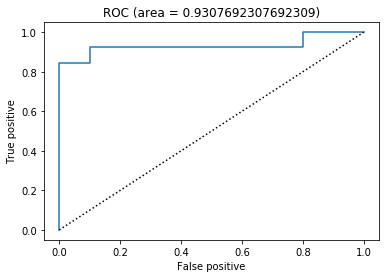

In [11]:
import matplotlib.pyplot as plot
import sklearn.metrics

predictions = model.predict(test_image_generator)
positive_predictions = predictions[:, 1]

fpr, tpr, _ = metrics.roc_curve(actual, positive_predictions)
roc_auc = metrics.auc(fpr, tpr)

plot.title(f'ROC (area = {roc_auc})')
plot.plot(fpr, tpr)
plot.plot([0, 1], [0, 1], ':k')
plot.xlabel('False positive')
plot.ylabel('True positive')

## Save model

In [12]:
model.save('pokemon_type_model.h5')